In [1]:
import jax
import jax.numpy as jnp
import scipy
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity, legend
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    get_biological_age,
    piecewise_linear_bases,
    neg_log_likelihood_v2
)
from sklearn.model_selection import StratifiedShuffleSplit
from itertools import product

In [2]:
warnings.simplefilter("ignore")

In [3]:
format_plots()

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 50
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

## Run held-out fitting to determine number of splines

In [41]:
def fit_params(counts, n_splines, age):
    spline_class, splines = create_splines(age_samples, df=n_splines)
    scale = 0.2

    A = spline_class.transform(age_normalizer(age)).T

    theta_list = []
    for i in range(n_syllables):
        _theta, _ = scipy.optimize.nnls(A.T, (counts + 1)[:, i] * scale)
        theta_list.append(_theta)
    theta_list = np.array(theta_list).T
    theta_list = np.where(theta_list == 0, 1e-3, theta_list)
    params = {'basis_weights': jnp.log(jnp.array(theta_list.T))}
    return params

In [6]:
def create_masks(n_keep_sylls, n_syllables, n_sessions, rng):
    mask = (
        np.arange(n_sessions)[:, None],
        np.array([rng.choice(n_syllables, size=n_keep_sylls, replace=False) for _ in range(n_sessions)]),
    )
    heldout_mask = (
        np.arange(n_sessions)[:, None],
        np.array([list(set(range(n_syllables)) - set(x)) for x in mask[1]])
    )
    return mask, heldout_mask

In [7]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 20
n_sessions = len(syllable_counts_jax)

# masks, heldout_masks = create_masks(keep_syllables, n_syllables, n_sessions, rng)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
    # "mask": masks,
    # "heldout_mask": heldout_masks,
}

# pbar = tqdm(list(product(range(10, 28, 3), jnp.linspace(1, 10, 5))))
pbar = tqdm(range(4, 15, 2))

out_ll = {}

# for n_splines, age_sd in pbar:
for n_splines in pbar:
    rng = np.random.RandomState(3)
    spline_class, splines = create_splines(age_samples, df=n_splines)
    # hypparams["age_sd"] = age_normalizer(age_sd + 1)

    params = fit_params(syllable_counts_jax, n_splines, age)

    lls = []
    for i in range(3):
        hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)
        ll_fun = partial(
            neg_log_likelihood,
            bases=splines,
            age_samples=age_samples,
            true_age=age_normalizer(age),
            counts=syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=False,
        )
        optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

        heldout_nll = neg_log_likelihood(
            optimized_params,
            splines,
            age_samples,
            age_normalizer(age),
            syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=True,
        )
        # out_ll[(n_splines, float(age_sd.item()), i)] = -heldout_nll
        out_ll[(n_splines, i)] = -heldout_nll
        lls.append(-heldout_nll)
        # print("n_splines", n_splines, "sd", hypparams["params_sd"], "ll", -heldout_nll)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
heldout_ll_df = (
    pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
    # .rename_axis(["n_splines", "age_sd", "fold"], axis=1)
    .rename_axis(["n_splines", "fold"], axis=1)
    .melt(value_name="log_likelihood")
)
# heldout_ll_df['age_sd'] = heldout_ll_df['age_sd'].round(2)

In [9]:
# hm = heldout_ll_df.pivot_table(
#     values="log_likelihood",
#     index="age_sd",
#     columns="n_splines",
#     aggfunc="mean",
# )
# sns.heatmap(hm, cbar_kws=dict(label="Heldout LL"))

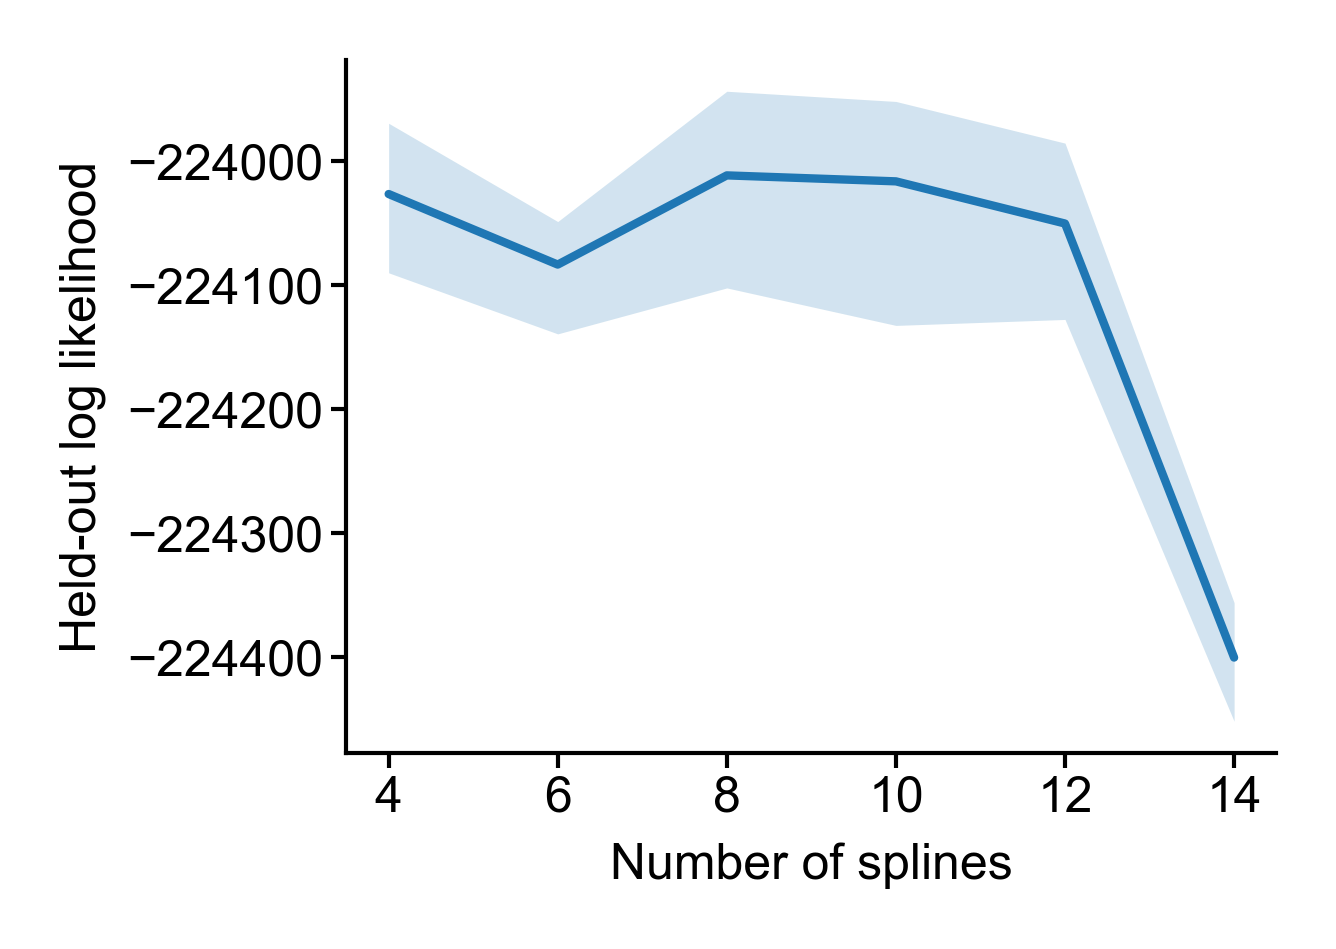

In [10]:
fig = figure(2, 1.5)
ax = sns.lineplot(data=heldout_ll_df, x="n_splines", y="log_likelihood", err_kws=dict(lw=0))
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
sns.despine()

In [11]:
heldout_ll_df.groupby("n_splines")["log_likelihood"].mean().sort_values(ascending=False)

n_splines
8    -224011.276042
10   -224016.093750
4    -224026.322917
12   -224050.145833
6    -224083.291667
14   -224400.583333
Name: log_likelihood, dtype: float64

In [12]:
bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [ ]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Test feature importance code with just bio age

In [42]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 20
n_sessions = len(syllable_counts_jax)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}
n_splines = 5

rng = np.random.RandomState(3)
spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

heldout_nll = neg_log_likelihood(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

### With jax gradients

In [43]:
bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [44]:
def expected_syllable_frequencies(z, theta_age, B_age):
    bio_age = z

    def spline_interpolation(x, B):
        return jnp.interp(x, jnp.linspace(0, 1, 1000), B)

    spline_interpolation = jax.vmap(spline_interpolation, in_axes=(None, 0))

    B_at_age = spline_interpolation(bio_age, B_age)  # shape (K_age)
    bio_concentrations = jnp.dot(theta_age, B_at_age)  # shape (M)

    concentrations = bio_concentrations  # shape (M)

    # expected syllable frequencies
    expected_frequences = concentrations / jnp.sum(concentrations)

    return expected_frequences


def fold_dependencies(z, theta_age, B_age):
    fun = partial(
        expected_syllable_frequencies,
        theta_age=theta_age,
        B_age=B_age,
    )
    J = jax.jacfwd(fun)(z)
    exp_freqs = fun(z)

    # J has shape (M, 2)
    # J[i,0] = d expected_syllable_frequencies[i] / d bio_age

    # fold_dependence = J / exp_freqs[:, None] * z[None]
    fold_dependence = J * z[None]
    return fold_dependence

data = age_normalizer(bio_ages)
theta_age = optimized_params["basis_weights"]

age_samples = np.linspace(0, 1, 1000)
_, B_age = create_splines(age_samples, df=n_splines)

fold_fun = partial(fold_dependencies, theta_age=theta_age, B_age=B_age)
XX = jax.vmap(fold_fun, in_axes=(0, ))(data)

In [45]:
XX.shape

(360, 50)

Text(0, 0.5, 'syllables')

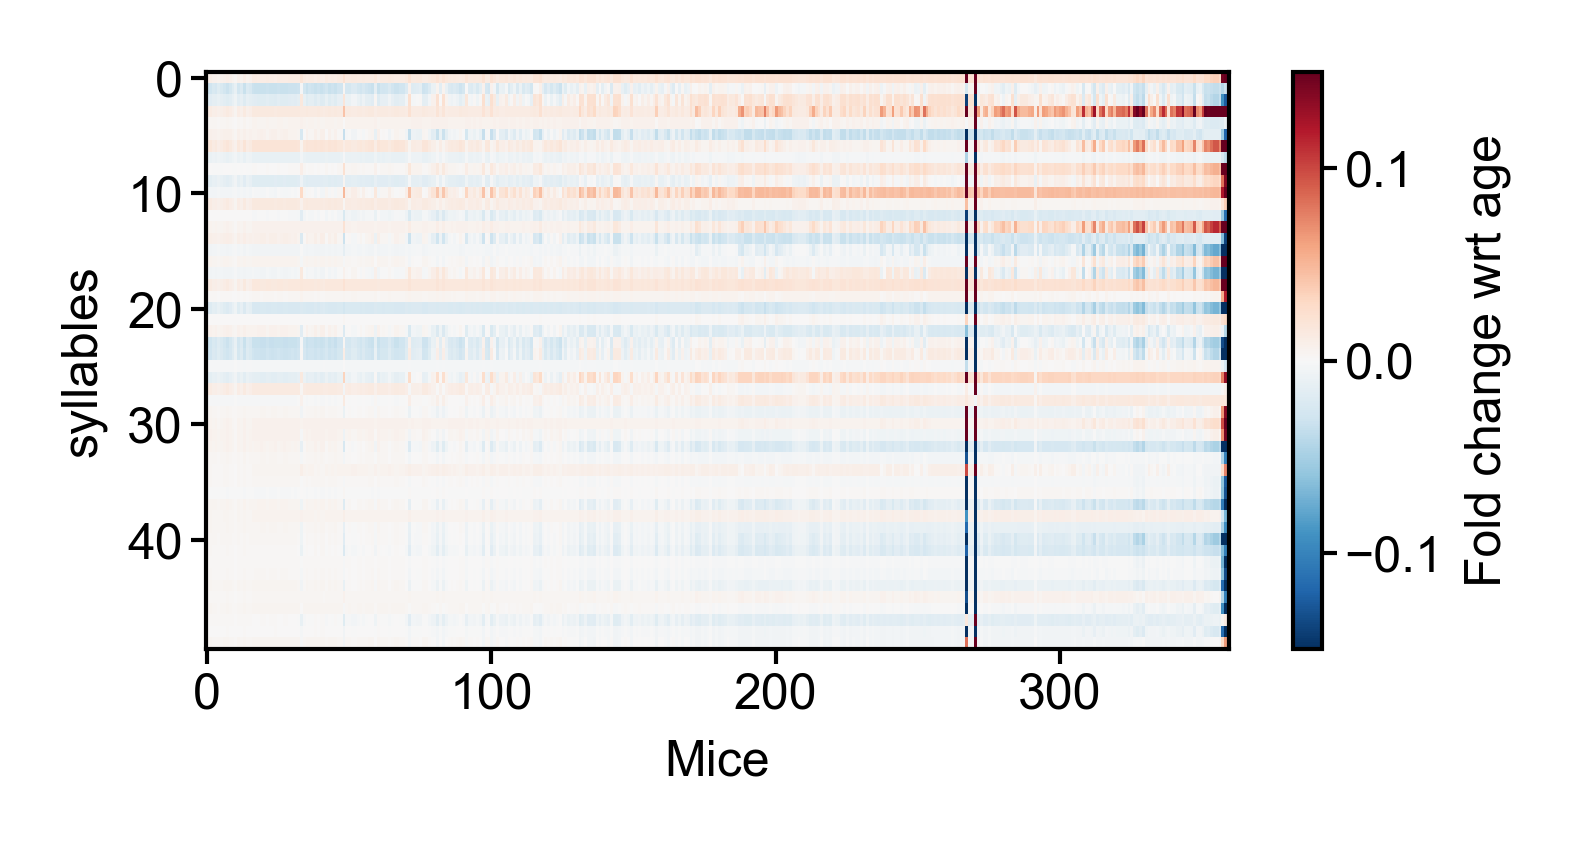

In [46]:
mag = 0.15
figure(2.75, 1.25)
plt.imshow(
    XX.T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt age")
plt.xlabel("Mice")
plt.ylabel("syllables")

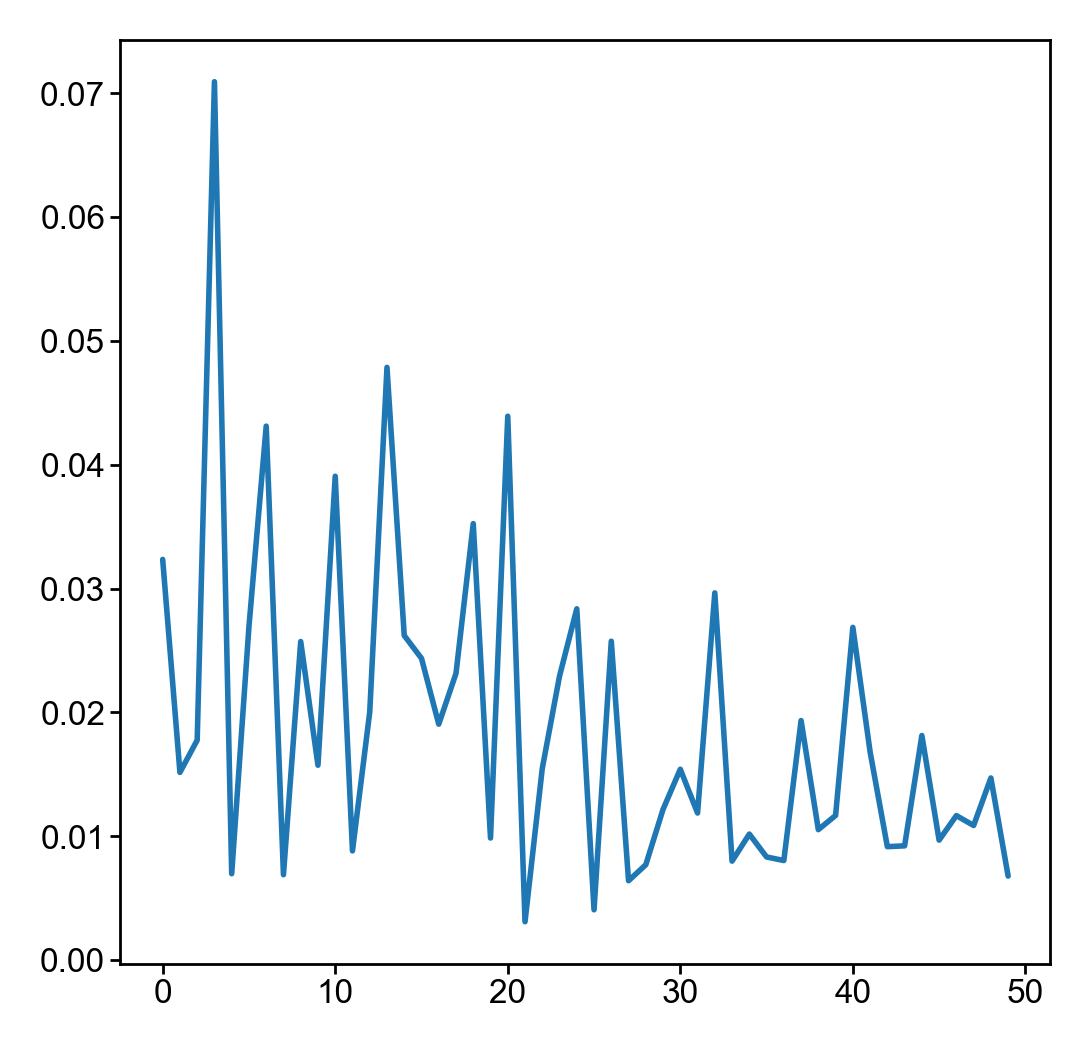

In [13]:
plt.plot(np.mean(np.abs(XX), axis=0))

## Add mouse size into fitting procedure

In [19]:
pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
size_df = pd.read_parquet(pth)

In [60]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()

def demean(ser: pd.Series):
    return ser - ser.mean()

In [64]:
sizes_col = size_df.groupby('age')[0.5].transform(demean)
sizes_col = sizes_col.loc[df.index]

In [62]:
def fit_params(counts, n_splines, age, n_size_splines, n_syllables):
    spline_class, splines = create_splines(age_samples, df=n_splines)
    scale = 0.2

    A = spline_class.transform(age_normalizer(age)).T

    theta_list = []
    for i in range(n_syllables):
        _theta, _ = scipy.optimize.nnls(A.T, (counts + 1)[:, i] * scale)
        theta_list.append(_theta)
    theta_list = np.array(theta_list).T
    theta_list = np.where(theta_list == 0, 1e-3, theta_list)
    params = {'bio_basis_weights': jnp.log(jnp.array(theta_list.T)), 'size_basis_weights': jnp.zeros((n_syllables, n_size_splines))}
    return params

In [25]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
size_normalizer, size_unnormalizer = age_normalizer_factory(min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 20
n_sessions = len(syllable_counts_jax)

n_size_splines = 5

# masks, heldout_masks = create_masks(keep_syllables, n_syllables, n_sessions, rng)

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.25,
    # "mask": masks,
    # "heldout_mask": heldout_masks,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

# pbar = tqdm(list(product(range(10, 28, 3), jnp.linspace(1, 10, 5))))
pbar = tqdm(range(4, 15, 2))

out_ll = {}

# for n_splines, age_sd in pbar:
for n_splines in pbar:
    rng = np.random.RandomState(3)
    spline_class, splines = create_splines(age_samples, df=n_splines)
    # hypparams["age_sd"] = age_normalizer(age_sd + 1)

    params = fit_params(syllable_counts_jax, n_splines, age, n_size_splines, n_syllables)

    basis_dict = {"bio": splines, "size": size_splines}

    lls = []
    for i in range(3):
        hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)
        ll_fun = partial(
            neg_log_likelihood_v2,
            bases=basis_dict,
            age_samples=age_samples,
            true_age=age_normalizer(age),
            counts=syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=False,
        )
        optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

        heldout_nll = neg_log_likelihood_v2(
            optimized_params,
            basis_dict,
            age_samples,
            age_normalizer(age),
            syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=True,
        )
        # out_ll[(n_splines, float(age_sd.item()), i)] = -heldout_nll
        out_ll[(n_splines, i)] = -heldout_nll
        lls.append(-heldout_nll)
        print("n_splines", n_splines, "ll", -heldout_nll)

  0%|          | 0/6 [00:00<?, ?it/s]

n_splines 4 ll -224174.7
n_splines 4 ll -224053.62
n_splines 4 ll -224049.2
n_splines 6 ll -224065.45
n_splines 6 ll -223941.5
n_splines 6 ll -223928.6
n_splines 8 ll -224088.2
n_splines 8 ll -223917.95
n_splines 8 ll -223884.92
n_splines 10 ll -224054.66
n_splines 10 ll -223788.94
n_splines 10 ll -223832.23
n_splines 12 ll -223987.53
n_splines 12 ll -223818.34
n_splines 12 ll -223835.61
n_splines 14 ll -224099.75
n_splines 14 ll -223927.53
n_splines 14 ll -223914.58


In [26]:
size_heldout_ll_df = (
    pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
    .rename_axis(["n_splines", "fold"], axis=1)
    .melt(value_name="log_likelihood")
)

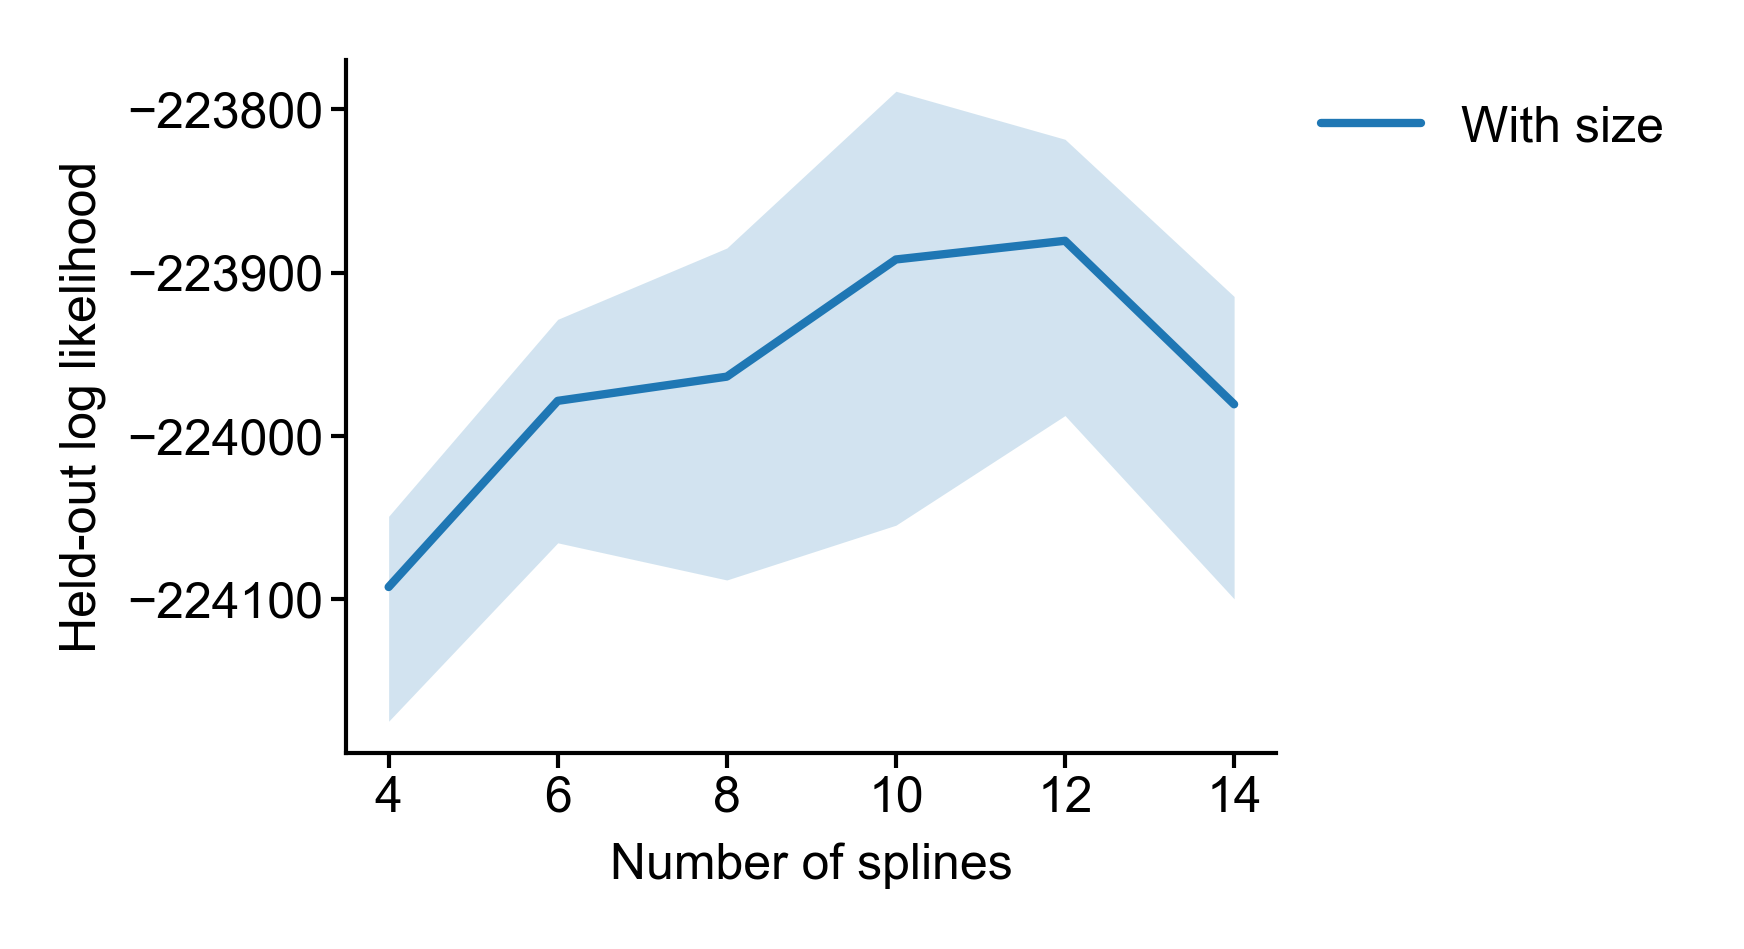

In [27]:
fig = figure(2, 1.5)
ax = sns.lineplot(
    data=size_heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="With size",
)
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
legend()
sns.despine()

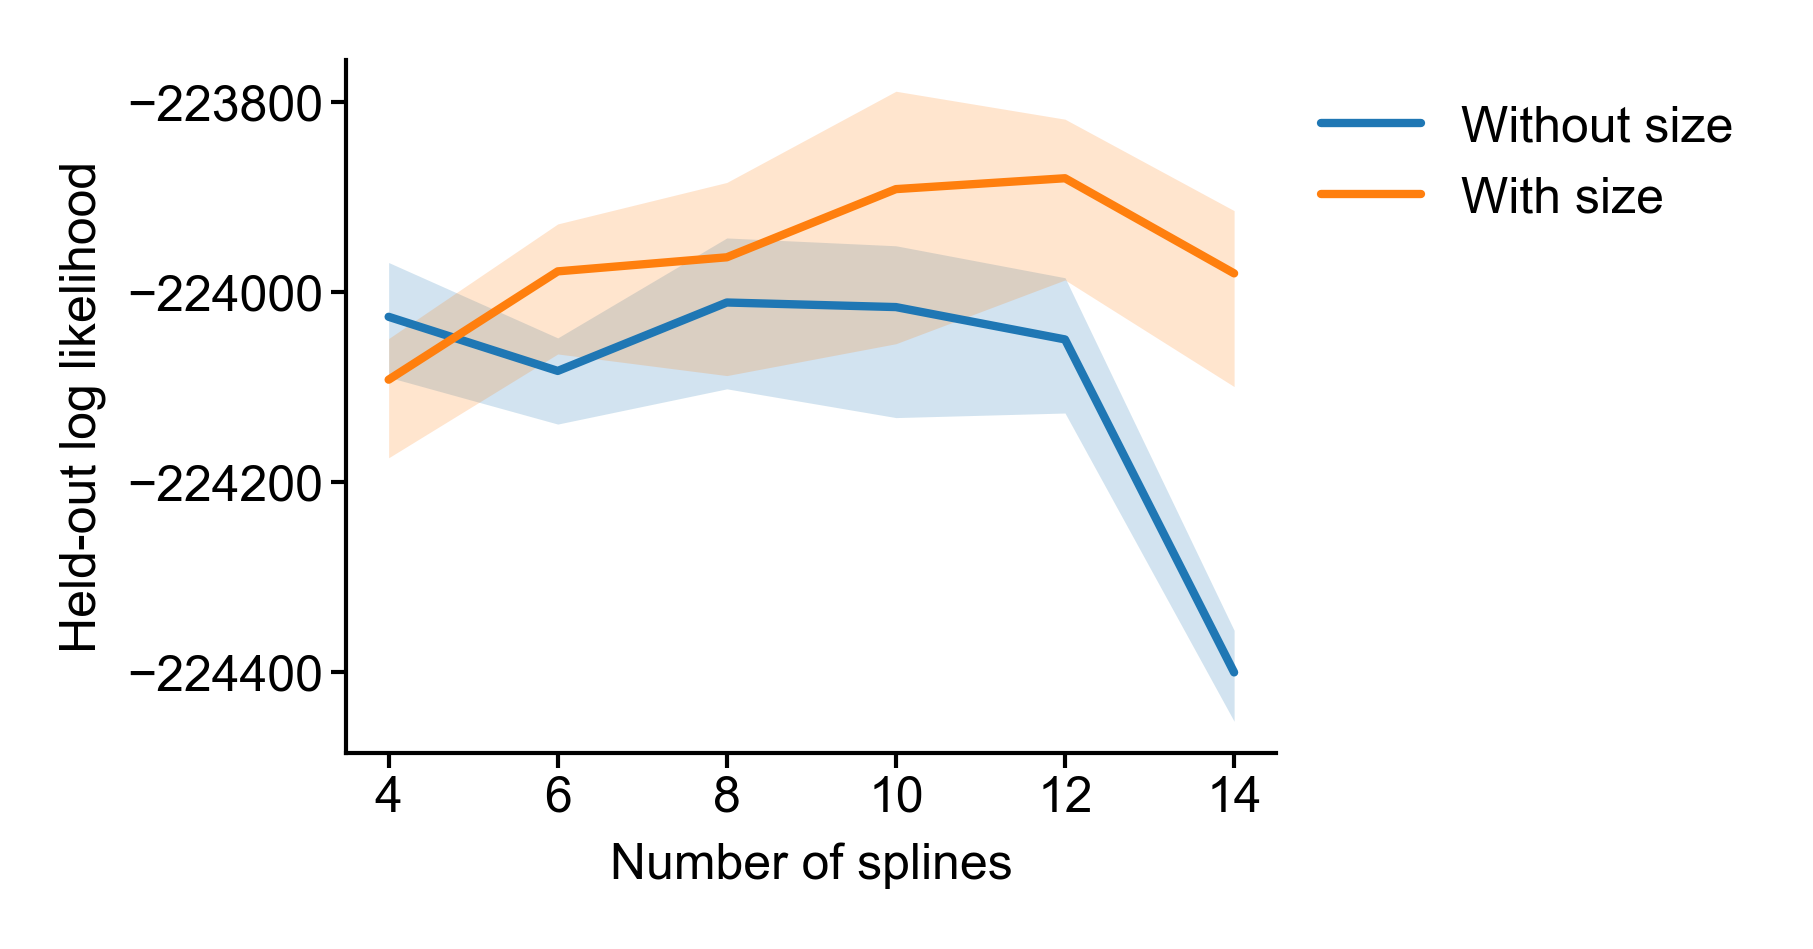

In [28]:
fig = figure(2, 1.5)
ax = sns.lineplot(
    data=heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="Without size",
)
ax = sns.lineplot(
    data=size_heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="With size",
)
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
legend()
sns.despine()

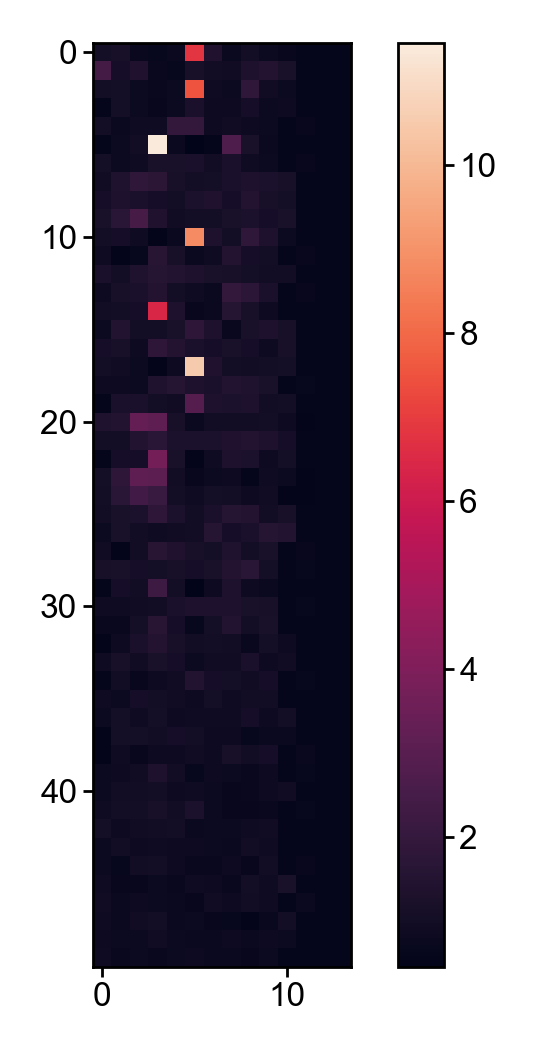

In [29]:
plt.imshow(jnp.exp(optimized_params['bio_basis_weights']))
plt.colorbar()

In [73]:
bio_concentrations = (
    jnp.exp(optimized_params["bio_basis_weights"]) @ basis_dict["bio"]
)  # shape (n_syllables, n_ages)
size_concentrations = (
    jnp.exp(optimized_params["size_basis_weights"]) @ basis_dict["size"]
)  # shape (n_syllables, n_sessions)

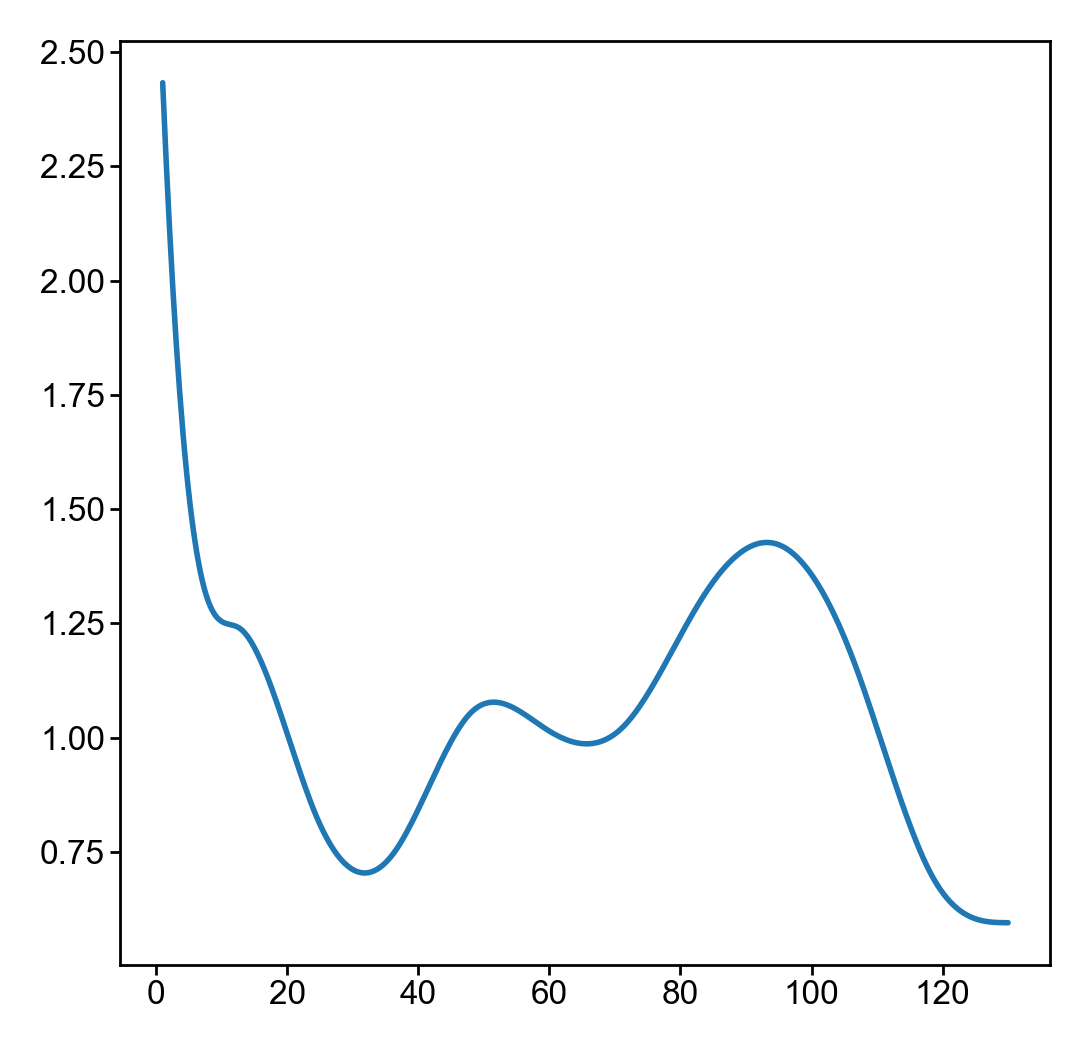

In [34]:
plt.plot(age_unnormalizer(age_samples), bio_concentrations[1])

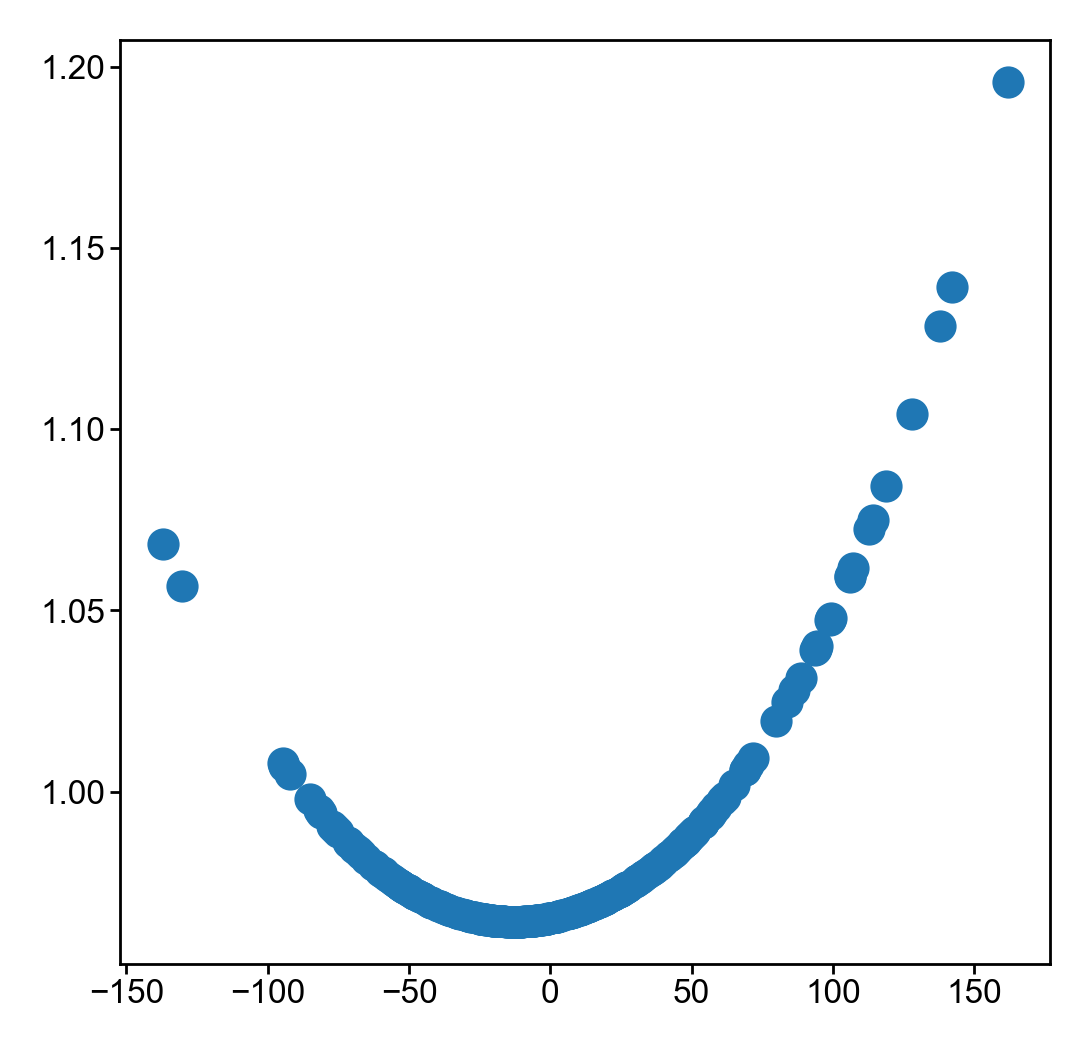

In [77]:
plt.plot(size_unnormalizer(sizes), size_concentrations[10], 'o')

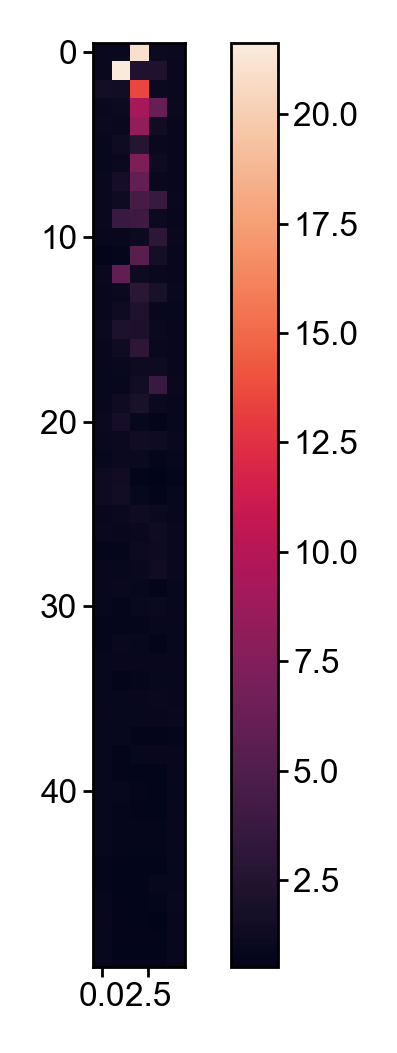

In [33]:
plt.imshow(jnp.exp(optimized_params['size_basis_weights']))
plt.colorbar()

## Test feature importance code

In [65]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
size_normalizer, size_unnormalizer = age_normalizer_factory(min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 20
n_sessions = len(syllable_counts_jax)

n_size_splines = 5
n_splines = 5

# masks, heldout_masks = create_masks(keep_syllables, n_syllables, n_sessions, rng)

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

out_ll = {}

rng = np.random.RandomState(3)
spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age, n_size_splines, n_syllables)

basis_dict = {"bio": splines, "size": size_splines}

lls = []
for i in range(3):
    hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)
    ll_fun = partial(
        neg_log_likelihood_v2,
        bases=basis_dict,
        age_samples=age_samples,
        true_age=age_normalizer(age),
        counts=syllable_counts_jax + 1,
        hypparams=hypparams,
        heldout=False,
    )
    optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

    heldout_nll = neg_log_likelihood_v2(
        optimized_params,
        basis_dict,
        age_samples,
        age_normalizer(age),
        syllable_counts_jax + 1,
        hypparams=hypparams,
        heldout=True,
    )
    # out_ll[(n_splines, float(age_sd.item()), i)] = -heldout_nll
    out_ll[(n_splines, i)] = -heldout_nll
    lls.append(-heldout_nll)
    print("n_splines", n_splines, "ll", -heldout_nll)
    break

n_splines 5 ll -224049.6


### With jax gradients

In [66]:
def expected_syllable_frequencies(z, theta_age, theta_size, B_age, B_size):
    bio_age, size = z

    def spline_interpolation(x, B):
        return jnp.interp(x, jnp.linspace(0, 1, 1000), B)

    spline_interpolation = jax.vmap(spline_interpolation, in_axes=(None, 0))

    B_at_age = spline_interpolation(bio_age, B_age)  # shape (K_age)
    bio_concentrations = jnp.dot(theta_age, B_at_age)  # shape (M)

    B_at_size = spline_interpolation(size, B_size)  # shape (K_size)
    size_concentrations = jnp.dot(theta_size, B_at_size)  # shape (M)

    concentrations = bio_concentrations + size_concentrations  # shape (M)

    # expected syllable frequencies
    expected_frequences = concentrations / jnp.sum(concentrations)

    return expected_frequences


def fold_dependencies(z, theta_age, theta_size, B_age, B_size):
    # z = jnp.array([bio_age, size])
    fun = partial(
        expected_syllable_frequencies,
        theta_age=theta_age,
        theta_size=theta_size,
        B_age=B_age,
        B_size=B_size,
    )
    J = jax.jacfwd(fun)(z)
    exp_freqs = fun(z)

    # J has shape (M, 2)
    # J[i,0] = d expected_syllable_frequencies[i] / d bio_age
    # J[i,1] = d expected_syllable_frequencies[i] / d size

    # fold_dependence = J / exp_freqs[:, None] * z[None]
    fold_dependence = J * z[None]
    return fold_dependence

data = jnp.stack([
    age_normalizer(age),
    sizes,
], axis=1)

theta_age = optimized_params["bio_basis_weights"]
theta_size = optimized_params["size_basis_weights"]

age_samples = np.linspace(0, 1, 1000)

_, B_age = create_splines(age_samples, df=n_splines)
_, B_size = create_splines(age_samples, df=n_size_splines)

fold_fun = partial(fold_dependencies, theta_age=theta_age, theta_size=theta_size, B_age=B_age, B_size=B_size)
XX = jax.vmap(fold_fun, in_axes=(0, ))(data)

In [67]:
XX.shape

(360, 50, 2)

In [68]:
mags = np.median(np.abs(XX), axis=0)

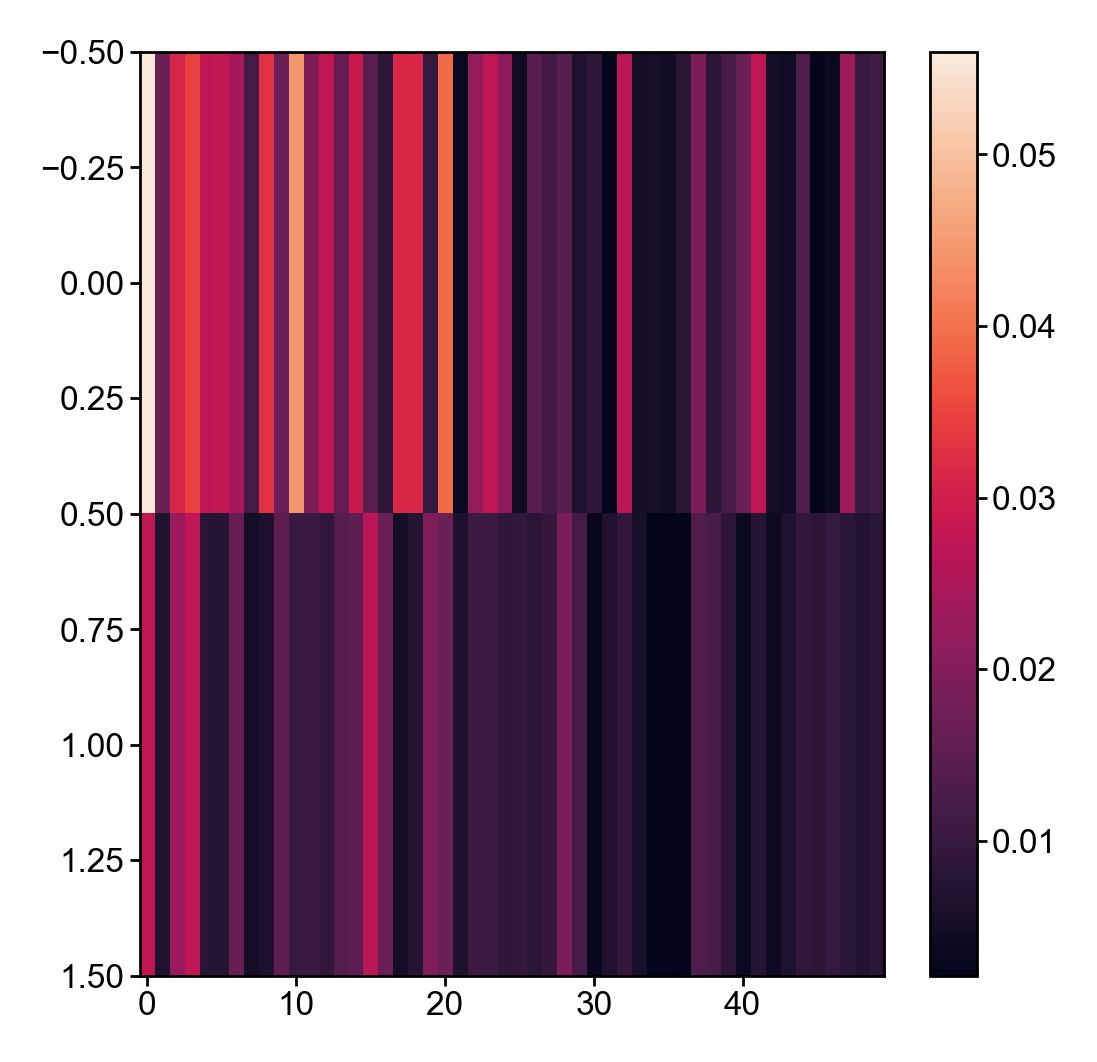

In [69]:
plt.imshow(mags.T, aspect='auto')
plt.colorbar()

([<matplotlib.axis.XTick at 0x7fe5e4102f20>,
 [Text(0, 0, 'age'), Text(1, 0, 'size')])

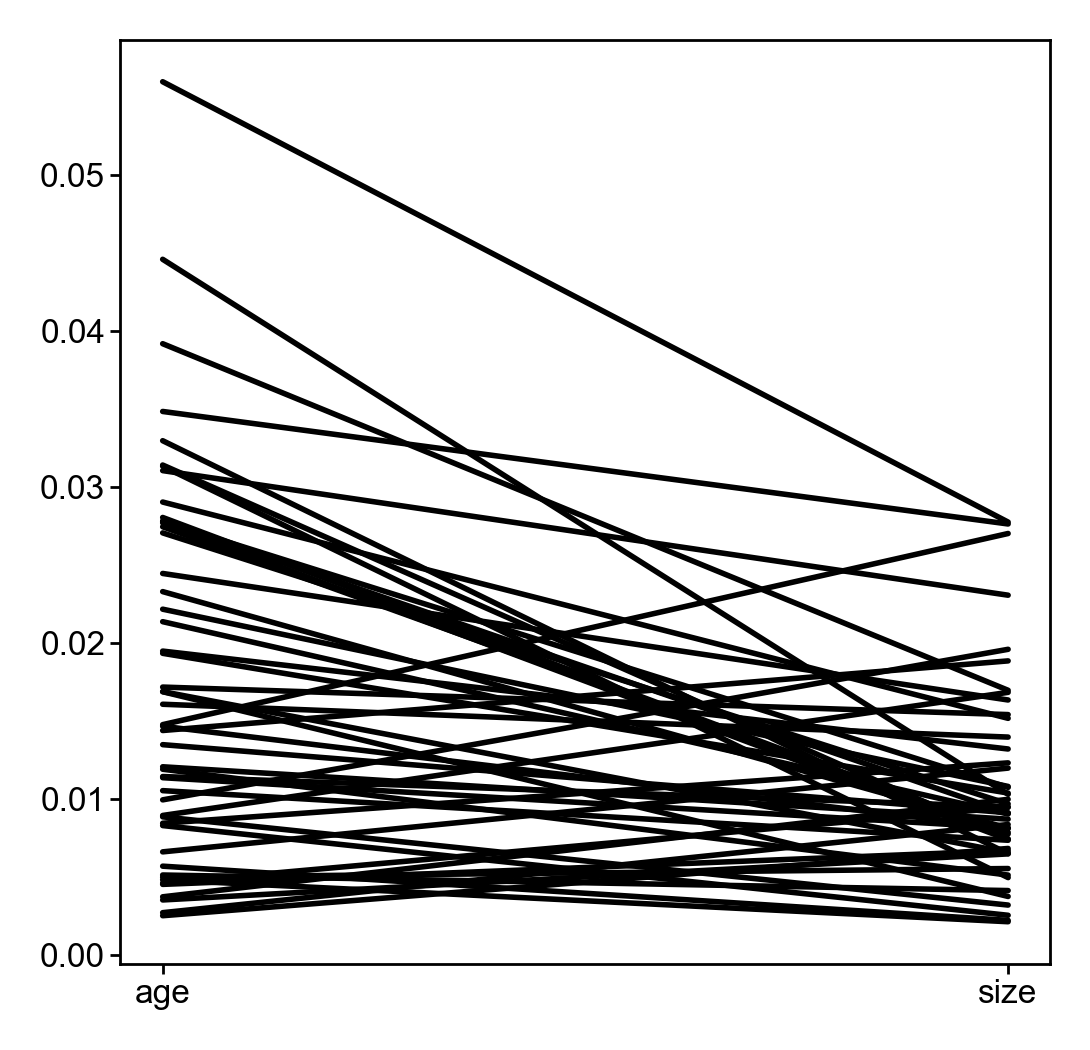

In [70]:
for line in mags:
    plt.plot([0, 1], line, c='k')
plt.xticks([0, 1], ["age", "size"])

Text(0, 0.5, 'syllables')

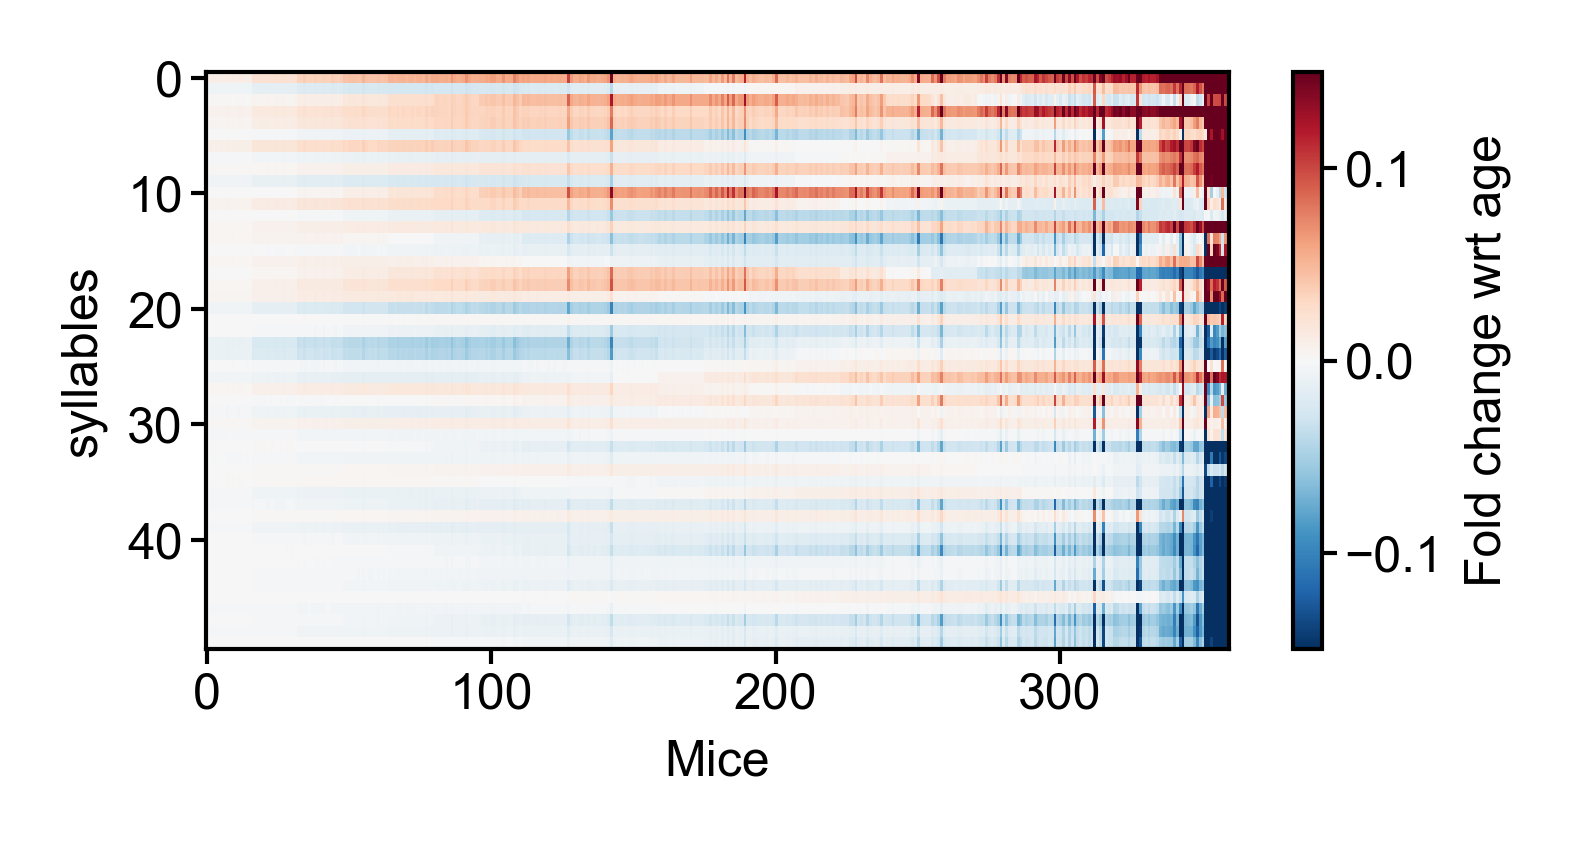

In [71]:
figure(2.75, 1.25)
mag = 0.15
plt.imshow(
    XX[..., 0].T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt age")
plt.xlabel("Mice")
plt.ylabel("syllables")

Text(0, 0.5, 'syllables')

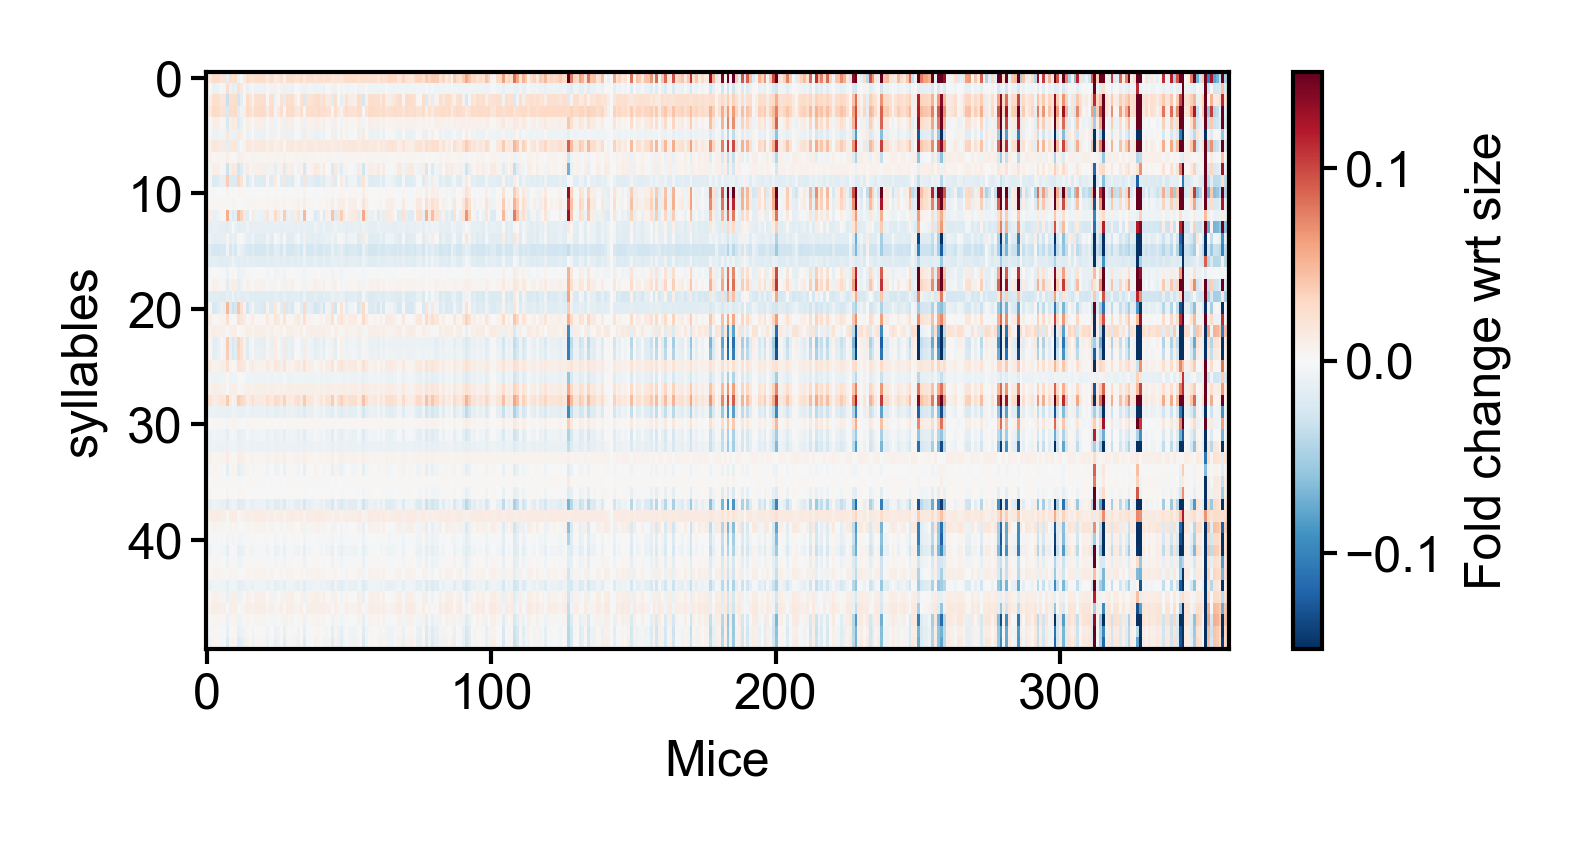

In [72]:
figure(2.75, 1.25)
plt.imshow(
    XX[..., 1].T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt size")
plt.xlabel("Mice")
plt.ylabel("syllables")